In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import imp
import pymaster as nmt
import utils
from multiprocessing import Pool, cpu_count

%matplotlib inline

In [2]:
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc 

In [3]:
from Fg_template import sync_ps as sync_ps_v0
from Fg_template import dust_ps as dust_ps_v0
from Fg_template import corre_fore_simple

In [4]:
import logLikeli

In [5]:
imp.reload(logLikeli)

<module 'logLikeli' from '/home/jianyao/Likelihood/logLikeli.py'>

In [6]:
from logLikeli import logLike

In [31]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0904_Ali_2fre_with_beam_new_noise_1024/No_beam/'
cl_f_all = np.load('%s/cl_f_all.npy'%path); 
cl_hat_all = np.load('%s/cl_hat_all.npy'%path) 

nl_all = np.load('%s/nl_all.npy'%path)
nl_mean = np.mean(nl_all, axis = 0) ## EE EB BB

A_s_RJ = np.load('%s/s30_RJ.npy'%path); 
A_d_RJ = np.load('%s/d353_RJ.npy'%path);

In [16]:
# path = '/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise'
# cl_f_all = np.load('%s/cl_f_all.npy'%path);
# cl_hat_all = np.load('%s/cl_hat_fore_all.npy'%path) 

# nl_all = np.load('%s/nl_all.npy'%path)
# nl_mean = np.mean(nl_all, axis = 0) ## EE EB BB

# A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
# A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')

In [32]:
# nside = 128; bin_w = 20; lmax = 201; SamNum = 100; lbin = 10
nside = 1024; bin_w = 20; lmax = 501; SamNum = 50; lbin = 25;

logltest = logLike(2,nside, bin_w, lmax)

logltest.M(cl_f_all = cl_f_all, SamNum=cl_f_all.shape[0], method = 'oas')

### new way

In [33]:
results = logltest.dynesty_run(cl_hat_all[0][2], nl_mean[2], A_s_RJ, A_d_RJ, 1, 10)

1021it [00:53, 19.23it/s, +400 | bound: 0 | nc: 1 | ncall: 4706 | eff(%): 30.195 | loglstar:   -inf < -1.046 <    inf | logz: -2.555 +/-  0.042 | dlogz:  0.001 >  0.409]


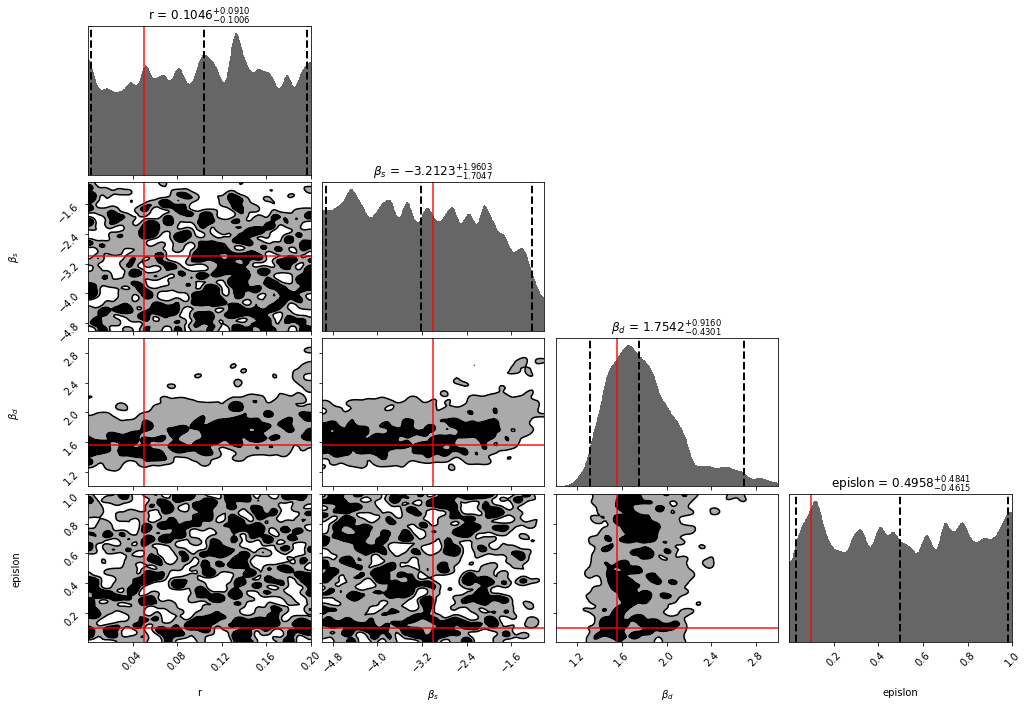

In [34]:
truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];
  
labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
npara = len(labels)
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

In [ ]:
best_fit = np.ones(4)
weights = np.atleast_1d(weights)
q = np.array((0.5))
q = np.atleast_1d(q)

for i in range(4):
    
    x = np.atleast_1d(samples[:,i])
    idx = np.argsort(x)  # sort samples
    sw = weights[idx]  # sort weights
    cdf = np.cumsum(sw)[:-1]  # compute CDF
    cdf /= cdf[-1]  # normalize CDF
    cdf = np.append(0, cdf)  # ensure proper span
    best_fit[i] = (np.interp(q, cdf, x[idx]).tolist())[0]

### old way

In [43]:
npara = 4; Nsim = 1; sbin = 1; ebin = 10

def prior(cube):
    
    r = cube[0]*0.3
    beta_s = cube[1]*2 - 4## from -4 to -2
#     beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
    beta_d = cube[2]*2 + 1 
    epsilon = cube[3];
    
    return [r, beta_s, beta_d, epsilon]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim); Results = []
# LogL.Cov = LogL.Cov*10.0;

for n in range(0, Nsim):
    
    cl_hat_fore_ali = cl_hat_all[n][2]
      
    def log_likelihood(cube, subtract = False):
        
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];
        epsilon = cube[3];

        cl_th_test = logltest.combine_ps(r_i)  ## combine the tensor bb and lensing bb
        
        fl_hat = sync_ps_v0(A_s_RJ, beta_s, lbin) + dust_ps_v0(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)
        
        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean[2] + fl_hat
        
        logL = logltest.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, likelihood='HL', sbin=sbin, ebin = ebin); 

        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested()
        results = sampler.results
    Results.append(results)
    
    if n == 0 : 
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
    else: 
        _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
        samples = np.r_[samples, _samples];
        weights = np.r_[weights, _weights];

5323it [00:19, 267.54it/s, +400 | bound: 21 | nc: 1 | ncall: 26803 | eff(%): 21.352 | loglstar:   -inf < -12.405 <    inf | logz: -24.755 +/-  0.242 | dlogz:  0.001 >  0.409]


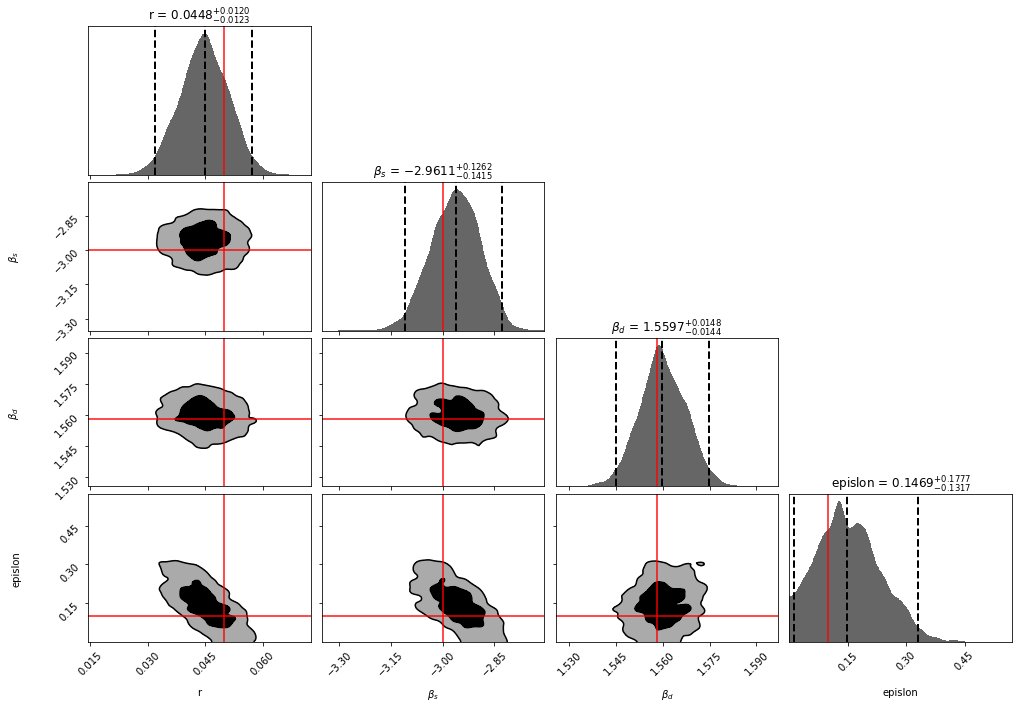

In [44]:
truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];
  
labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
npara = len(labels)
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

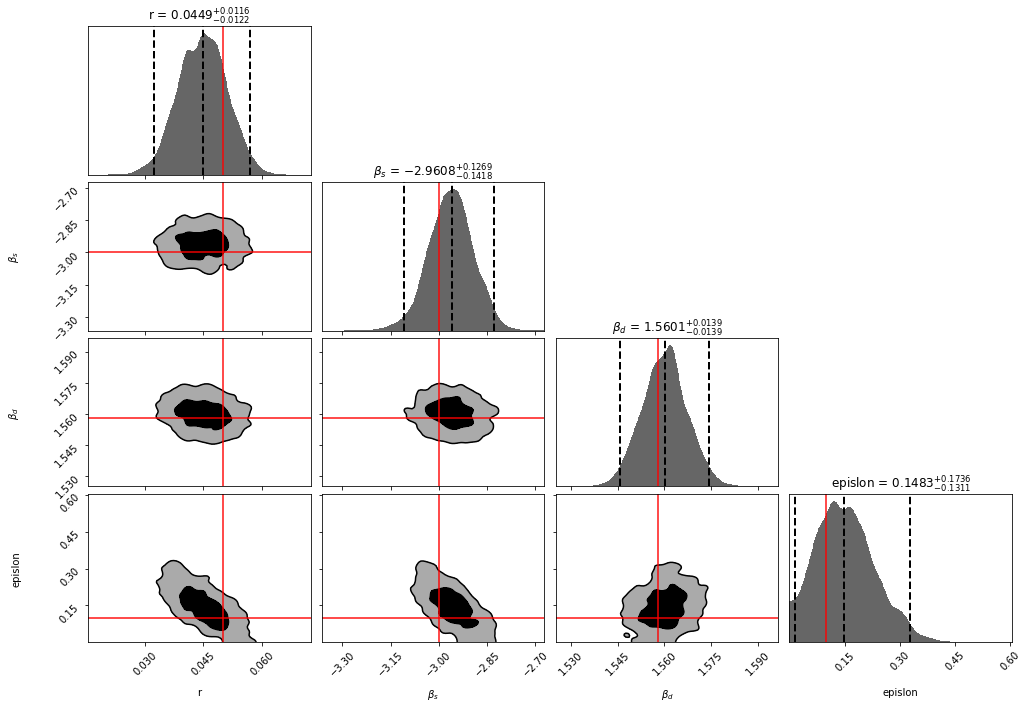

In [187]:
truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];
  
labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
npara = len(labels)
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

### new

In [31]:
from sympy import *

r, theta = symbols('r, theta')
# polar to cartesian
fx = r * cos(theta)
fy = r * sin(theta)

# base vector
erx = diff(fx, r)
ery = diff(fy, r)
etx = diff(fx, theta)
ety = diff(fy, theta)

# base vector changes.
erxr = diff(erx, r)
eryr = diff(ery, r)
etxr = diff(etx, r)
etyr = diff(ety, r)

erxt = diff(erx, theta)
eryt = diff(ery, theta)
etxt = diff(etx, theta)
etyt = diff(ety, theta)

# christoffel symbol
print("solve equations=============")
a, b = symbols('Gamma^r_rr, Gamma^theta_rr')
eq1 = a * erx + b * etx - erxr
eq2 = a * ery + b * ety - eryr
print_latex(solve([eq1, eq2], [a, b]))

a = Symbol('\\Gamma^r_{\\theta r}')
b = Symbol('\\Gamma^\\theta_{\\theta r}')
eq1 = a * erx + b * etx - etxr
eq2 = a * ery + b * ety - etyr
print_latex(solve([eq1, eq2], [a, b]))

a = Symbol('\\Gamma^r_{r \\theta}')
b = Symbol('\\Gamma^\\theta_{r \\theta}')
eq1 = a * erx + b * etx - erxt
eq2 = a * ery + b * ety - eryt
print_latex(solve([eq1, eq2], [a, b]))

a = Symbol('\\Gamma^r_{\\theta \\theta}')
b = Symbol('\\Gamma^\\theta_{\\theta \\theta}')
eq1 = a * erx + b * etx - etxt
eq2 = a * ery + b * ety - etyt
print_latex(solve([eq1, eq2], [a, b]))

solve equations=============
\left \{ \Gamma^{r}_{rr} : 0, \quad \Gamma^{\theta}_{rr} : 0\right \}
\left \{ \Gamma^\theta_{\theta r} : \frac{1}{r}, \quad \Gamma^r_{\theta r} : 0\right \}
\left \{ \Gamma^\theta_{r \theta} : \frac{1}{r}, \quad \Gamma^r_{r \theta} : 0\right \}
\left \{ \Gamma^\theta_{\theta \theta} : 0, \quad \Gamma^r_{\theta \theta} : - r\right \}


solve equations=============
$$\left \{ \Gamma^{r}_{rr} : 0, \quad \Gamma^{\theta}_{rr} : 0\right \}
\left \{ \Gamma^\theta_{\theta r} : \frac{1}{r}, \quad \Gamma^r_{\theta r} : 0\right \}
\left \{ \Gamma^\theta_{r \theta} : \frac{1}{r}, \quad \Gamma^r_{r \theta} : 0\right \}
\left \{ \Gamma^\theta_{\theta \theta} : 0, \quad \Gamma^r_{\theta \theta} : - r\right \} $$

In [33]:
rotate = hp.rotator.Rotator(coord=['G','C'])

In [51]:
cmb_map_i = np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%0)

cmb_map_beamed = hp.smoothing(rotate.rotate_map_pixel(cmb_map_i), fwhm = 19/60/180*np.pi, lmax = lmax, verbose = False);

cmb_map_i = np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%0)
cmb_map_rotate = rotate.rotate_map_pixel(hp.smoothing((cmb_map_i), fwhm = 11/60/180*np.pi, lmax = lmax, verbose = False))

In [52]:
cmb_map_i = np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%0)
cmb_map_beam_only = hp.smoothing((cmb_map_i), fwhm = 11/60/180*np.pi, lmax = lmax, verbose = False)

In [74]:
cmb_map_i = np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%0)
cmb_rotate_only = rotate.rotate_map_pixel(cmb_map_i)                    

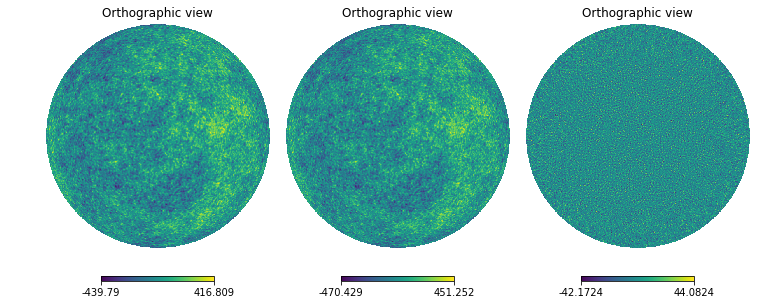

In [43]:
plt.figure(figsize= (10,8))
hp.orthview(cmb_map_beamed[0], sub = 131, half_sky=1); hp.orthview(cmb_map_rotate[0], sub = 132, half_sky=1); hp.orthview(cmb_map_rotate[0] - cmb_map_beamed[0], sub = 133, half_sky=1)

In [48]:
cl_beamed = hp.anafast(cmb_map_beamed, lmax = lmax)
cl_rotate = hp.anafast(cmb_map_rotate, lmax = lmax)

In [53]:
cl_beam_only = hp.anafast(cmb_map_beam_only, lmax = lmax)

In [75]:
cl_cmb = hp.anafast(cmb_map_i, lmax = lmax)
cl_rotate_only = hp.anafast(cmb_rotate_only, lmax = lmax)

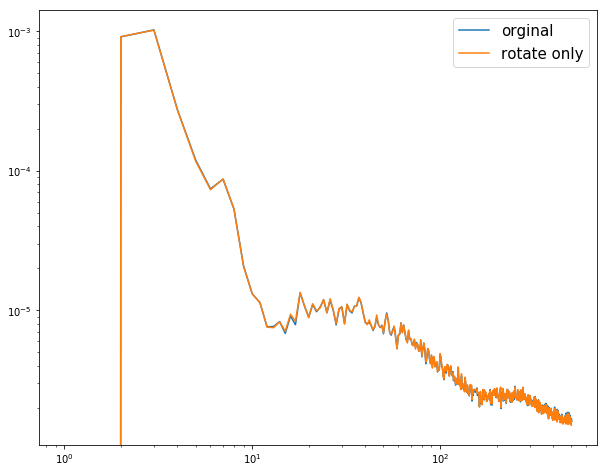

In [76]:
plt.figure(figsize = (10,8))
plt.loglog(cl_cmb[2], label = 'orginal')
plt.loglog(cl_rotate_only[2], label = 'rotate only')
plt.legend(fontsize = 15)

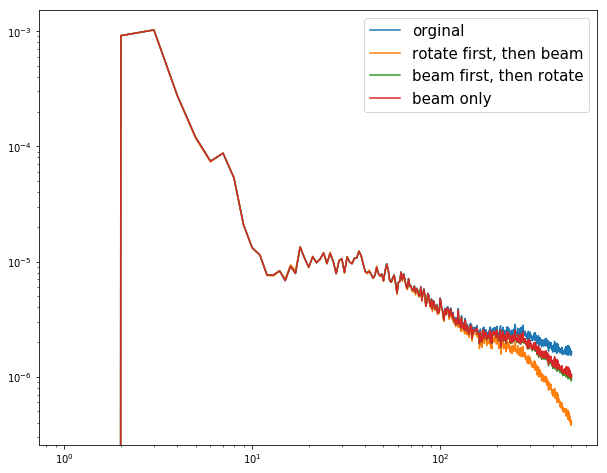

In [78]:
plt.figure(figsize = (10,8))
plt.loglog(cl_cmb[2], label = 'orginal')
plt.loglog(cl_beamed[2], label = 'rotate first, then beam')
plt.loglog(cl_rotate[2], label = 'beam first, then rotate')
plt.loglog(cl_beam_only[2], label = 'beam only')

plt.legend(fontsize = 15)

In [86]:
import multiprocessing
p = multiprocessing.Pool(processes = 16)

In [106]:
def func(x):
    return x**2
test = []
for i in range(10):
    test.append(p.apply_async(func, [i]))
# print(result)

In [107]:
test_results = [p.get() for p in test]

In [108]:
test_results

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

### downgrade

In [42]:
nIQU = hp.read_map('/fnx/jianyao/ffp10_noise_353_full_map_mc_00000.fits', field = None)*1e6

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [43]:
nl_2048 = hp.anafast(nIQU[0])

In [52]:
nIQU_512 = hp.ud_grade(nIQU[0], nside_out = 512)
nl_512 = hp.anafast(nIQU_512)

nIQU_256 = hp.ud_grade(nIQU[0], nside_out=256)
nl_256 = hp.anafast(nIQU_256)

In [49]:
nIQU_1024 = hp.ud_grade(nIQU[0], nside_out=1024)

In [50]:
nl_1024 = hp.anafast(nIQU_1024)

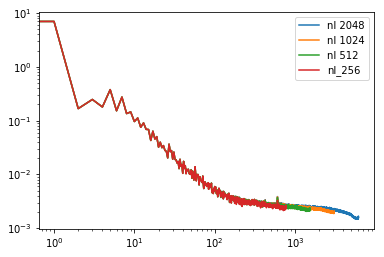

In [53]:
plt.loglog(nl_2048, label = 'nl 2048')
plt.loglog(nl_1024, label = 'nl 1024')
plt.loglog(nl_512, label = 'nl 512');
plt.loglog(nl_256, label = 'nl_256')
plt.legend()

In [78]:
alm_x = hp.map2alm(nIQU[0])

In [79]:
alm_x

array([ 0.78839419+0.j        ,  3.38076865+0.j        ,
       -0.01582128+0.j        , ..., -0.02084498+0.02016112j,
        0.01238224-0.03323688j,  0.0221744 +0.00920216j])

In [77]:
alm_x

array([ 0.78839419+0.j        ,  3.38076865+0.j        ,
       -0.01582128+0.j        , ..., -0.02084498+0.02016112j,
        0.01238224-0.03323688j,  0.0221744 +0.00920216j])

In [67]:
map_512 = hp.alm2map(alm_x, nside = 512)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [71]:
map_256 = hp.alm2map(alm_x, nside = 256)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [89]:
map_128 = hp.alm2map(alm_x, nside = 128)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [98]:
#(1) generating cmb-lensing-map from alm in different resolution (nside)
# map_2048 = hp.alm2map(alm_x,nside=2048)   #nside=4096

map_2048 = nIQU[0]

# map_1024 = hp.alm2map(alm_x,nside=1024)   #nside=1024

#(2) downgraded from higher-resolution map to lower-resolution map
map_2048_512 = hp.ud_grade(map_2048,nside_out=512)   #from nside=4096 to 512
map_2048_128 = hp.ud_grade(map_2048,nside_out=128)   #from nside=4096 to 128
map_2048_1024 = hp.ud_grade(map_2048,nside_out=1024)   #from nside=1024 to 128

#(3) compute power-spectrum
cl_2048_512 = hp.anafast(map_2048_512,alm=False)
cl_2048_128 = hp.anafast(map_2048_128,alm=False)
# cl_1024_128 = hp.anafast(map_1024_128,alm=False)
cl_2048_1024 = hp.anafast(map_2048_1024, alm = False)

In [68]:
cl_512 = hp.anafast(map_512)

In [65]:
cl_1024 = hp.anafast(map_1024)

In [72]:
cl_256 = hp.anafast(map_256)

In [90]:
cl_128 = hp.anafast(map_128)

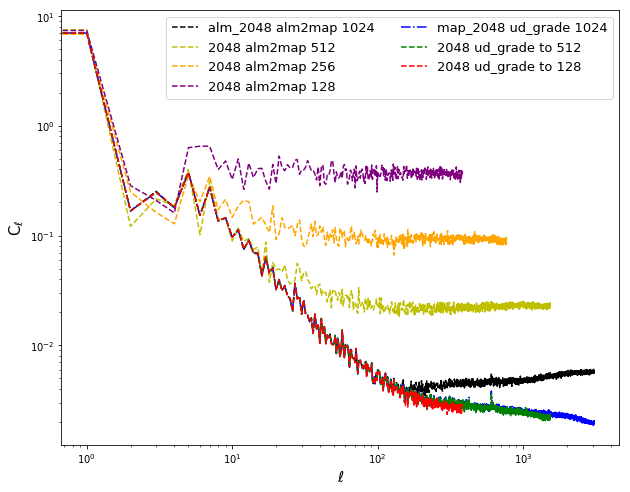

In [105]:
#(4)plot
plt.figure(figsize = (10,8))

plt.loglog(cl_1024, 'k--', label = 'alm_2048 alm2map 1024')
plt.loglog(cl_512, 'y--', label = '2048 alm2map 512')
plt.loglog(cl_256, c = 'orange',ls = '--', label = '2048 alm2map 256')
plt.loglog(cl_128, c = 'purple', ls = '--', label = '2048 alm2map 128')

plt.loglog(np.arange(len(cl_2048_1024)),cl_2048_1024,label='map_2048 ud_grade 1024',c='b',ls='-.')
plt.loglog(np.arange(len(cl_2048_512)),cl_2048_512,label='2048 ud_grade to 512',c='g',ls='--')
plt.loglog(np.arange(len(cl_2048_128)),cl_2048_128,label='2048 ud_grade to 128',c='r',ls='--')

plt.ylabel(r'C$_\ell$', fontsize = 15)
plt.xlabel(r'$\ell$', fontsize = 15)

plt.ylabel(r'C$_\ell$')
plt.legend(ncol = 2, fontsize = 13)

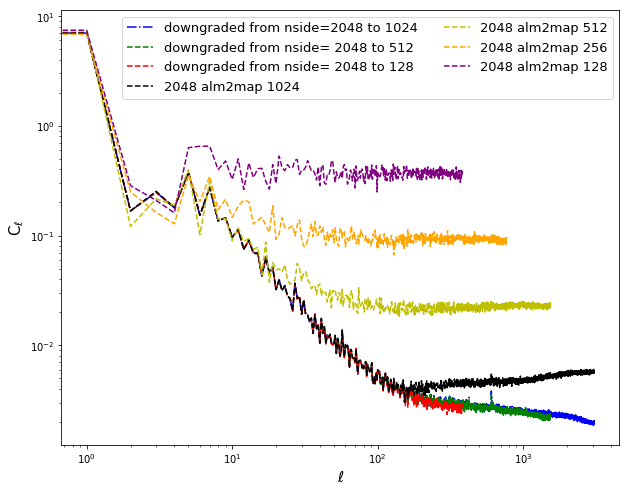

In [104]:
#(4)plot
plt.figure(figsize = (10,8))

plt.loglog(np.arange(len(cl_2048_1024)),cl_2048_1024,label='downgraded from nside=2048 to 1024',c='b',ls='-.')
plt.loglog(np.arange(len(cl_2048_512)),cl_2048_512,label='downgraded from nside= 2048 to 512',c='g',ls='--')
plt.loglog(np.arange(len(cl_2048_128)),cl_2048_128,label='downgraded from nside= 2048 to 128',c='r',ls='--')

plt.loglog(cl_1024, 'k--', label = '2048 alm2map 1024')
plt.loglog(cl_512, 'y--', label = '2048 alm2map 512')
plt.loglog(cl_256, c = 'orange',ls = '--', label = '2048 alm2map 256')
plt.loglog(cl_128, c = 'purple', ls = '--', label = '2048 alm2map 128')


plt.legend(ncol = 2, fontsize = 13)